# Introduction

#In the competitive financial sector, customer loyalty is crucial, as banks face significant risks from customer churn—the discontinuation of relationships, typically by account closures. This loss not only impacts future revenue from transaction fees and interest but also entails marketing costs to acquire new customers. Understanding the reasons behind customer churn is vital for banks. The dataset analyzed includes factors such as Credit Score, Balance, Product holdings, and Active Membership status, aiming to convert this data into valuable insights to enhance customer retention.

# Problem Statement

#How can the bank leverage its existing customer data to accurately predict which individuals are most likely to churn in the near future, allowing for targeted intervention strategies to increase customer retention?

# Import all Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

In [2]:
df=pd.read_csv("C:\\UMAR DATA\\Data Sciences\\Intership\\Developer Hub\\Bank Customer Churn Prediction.csv")
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Basic Data Understanding

In [3]:
df.drop(['customer_id'],axis='columns',inplace=True)
print(f'Shape of the Dataset:{df.shape}\n')
print(f'Null Values in Dataset:\n{df.isnull().sum()}\n')
print(f'Duplicated Values in Dataset:{df.duplicated().sum()}\n')
print(f'Drop Duplicated Values:{df.drop_duplicates(inplace=True)}\n')
print(f'Basic Information about Dataset:{df.info()}')

Shape of the Dataset:(10000, 11)

Null Values in Dataset:
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Duplicated Values in Dataset:0

Drop Duplicated Values:None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  


In [4]:
df_cate=df.select_dtypes(include='object')
df_category=df_cate.columns
print(f'Total Numbers of Categorical variable is {len(df_category)}')
df_num=df.select_dtypes(include='number')
df_number=df_num.columns
print(f'Total Number of Numerical data is {len(df_number)}')

Total Numbers of Categorical variable is 2
Total Number of Numerical data is 9


In [5]:
print(f'Basic Summary of Numerical Features:\n{df.describe()}')

Basic Summary of Numerical Features:
       credit_score           age        tenure        balance  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288   
std       96.653299     10.487806      2.892174   62397.405202   
min      350.000000     18.000000      0.000000       0.000000   
25%      584.000000     32.000000      3.000000       0.000000   
50%      652.000000     37.000000      5.000000   97198.540000   
75%      718.000000     44.000000      7.000000  127644.240000   
max      850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.45584       0.499797      57510.492818   
min           1.000000      0.00000       0.000000         11.580000   
25%     

In [6]:
print(f"Basic Summary of Categorical Features:\n{df.describe(include='object')}")

Basic Summary of Categorical Features:
       country gender
count    10000  10000
unique       3      2
top     France   Male
freq      5014   5457


# Exploratory Data Analysis

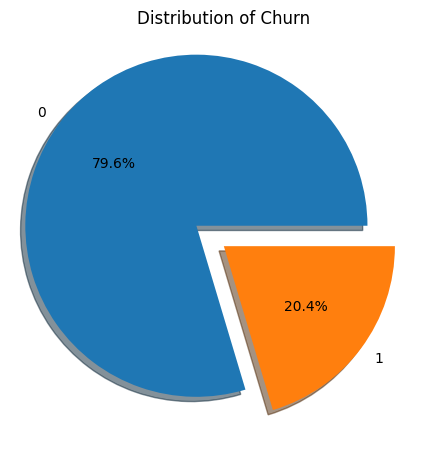

In [7]:
count=df.churn.value_counts()
index=np.argmax(count)
explode=[0.2 if i == index else 0 for i in range(len(count))]
plt.pie(count,labels=count.index,explode=explode,autopct='%1.1f%%',shadow=True)
plt.title("Distribution of Churn")
plt.tight_layout()

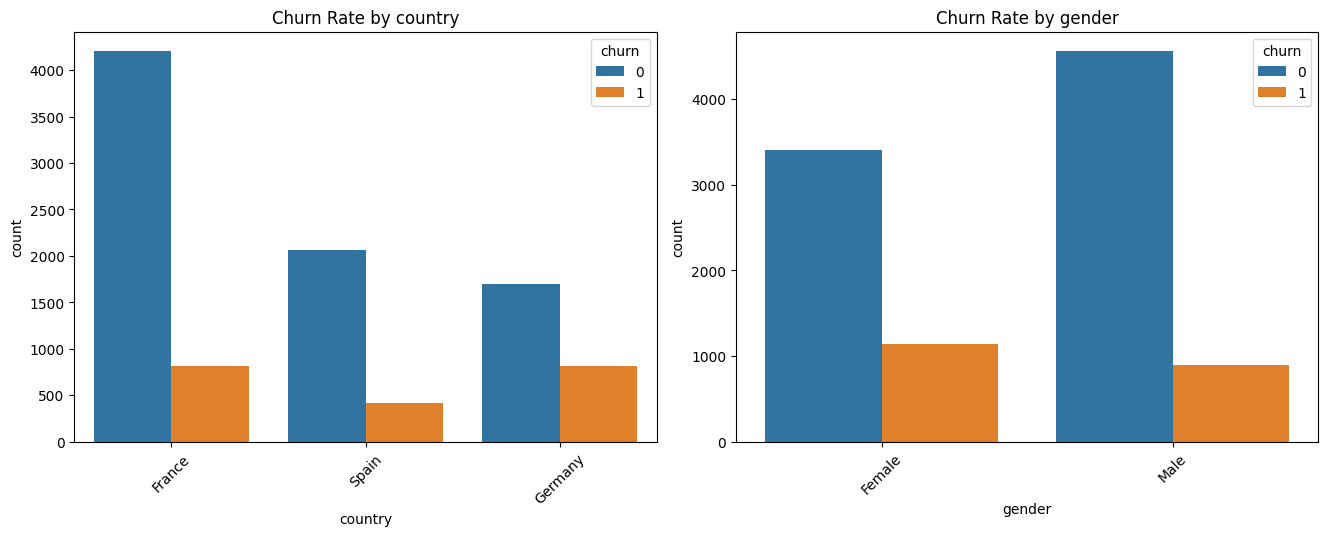

In [8]:
plt.figure(figsize=(20,25))
df_cate=df.select_dtypes(include='object')
for i,col in enumerate(df_cate):
    if col!='Churn':
        plt.subplot(5,3,i+1)
        sns.countplot(data=df,x=col,hue='churn')
        plt.title(f'Churn Rate by {col}')
        plt.xticks(rotation=45)
plt.tight_layout()

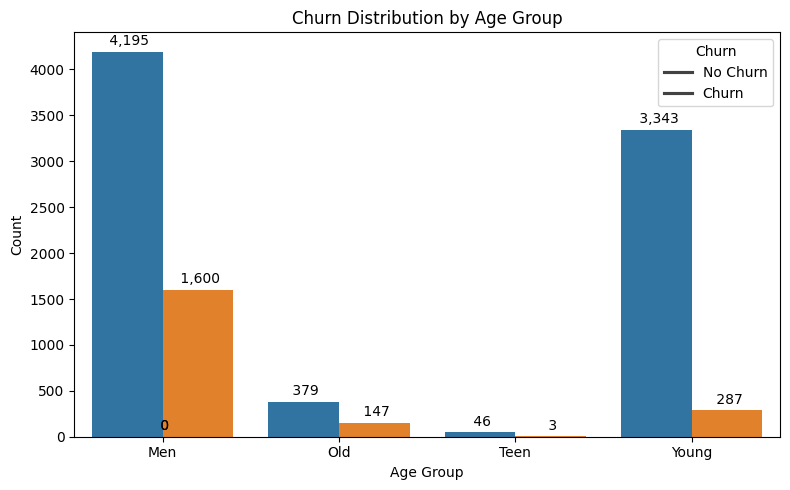

In [9]:
def age_group(age):
    if age < 20:
        return 'Teen'
    elif age < 35:
        return 'Young'
    elif age < 60:
        return 'Men'
    else:
        return 'Old'
df['age_group'] = df['age'].apply(age_group)
age_group = df.groupby(['age_group', 'churn']).size().reset_index(name='count')
plt.figure(figsize=(8, 5))
plot = sns.barplot(x='age_group', y='count', hue='churn', data=age_group)

for p in plot.patches:
    count = int(p.get_height())
    y_pos = p.get_height() + max(age_group['count']) * 0.01
    plot.annotate(f'{count: ,.0f}', 
                 (p.get_x() + p.get_width() / 2, y_pos),
                 ha='center', va='bottom')

plt.title('Churn Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

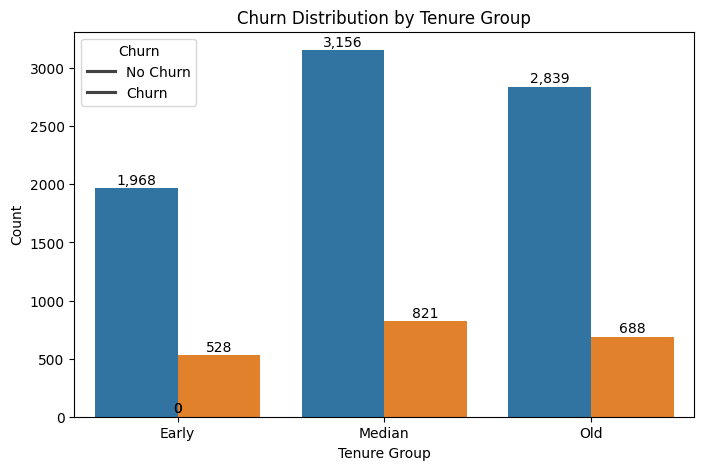

In [10]:
def tenure_group(tenure):
    if tenure < 3:
        return 'Early'
    elif tenure < 7:
        return 'Median'
    else:
        return 'Old'
df['tenure_group'] = df['tenure'].apply(tenure_group)
tenure_churn = df.groupby(['tenure_group', 'churn']).size().reset_index(name='count')
plt.figure(figsize=(8, 5))
plot = sns.barplot(x='tenure_group', y='count', hue='churn', data=tenure_churn)

for p in plot.patches:
    count = int(p.get_height())
    plot.annotate(f'{count:,.0f}', (p.get_x() + p.get_width() / 2, p.get_height() + 10), 
                  ha='center', va='bottom')

plt.title('Churn Distribution by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No Churn', 'Churn'])

C:\Users\Qadri Laptop\AppData\Local\Temp\ipykernel_10428\24381669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=feature, data=df, palette='Set1')
C:\Users\Qadri Laptop\AppData\Local\Temp\ipykernel_10428\24381669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=feature, data=df, palette='Set1')
C:\Users\Qadri Laptop\AppData\Local\Temp\ipykernel_10428\24381669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=feature, data=df, palette='Set1')


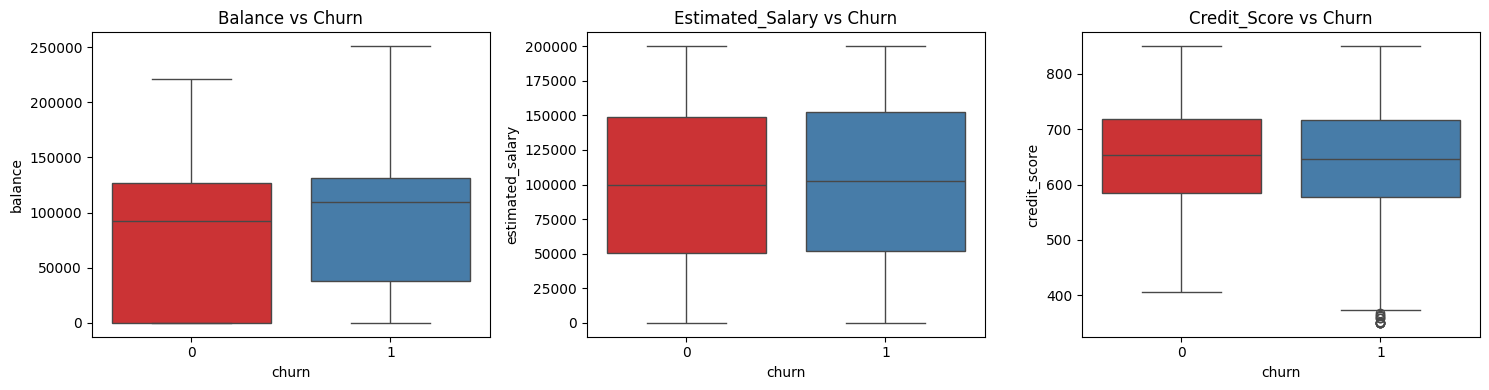

In [11]:
features = ['balance', 'estimated_salary', 'credit_score']
plt.figure(figsize=(15, 4))
for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='churn', y=feature, data=df, palette='Set1')
    plt.title(f'{feature.title()} vs Churn')
plt.tight_layout()
plt.show()

C:\Users\Qadri Laptop\AppData\Local\Temp\ipykernel_10428\233616280.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='churn', data=churn_rate, ax=axes[i], palette='coolwarm')
C:\Users\Qadri Laptop\AppData\Local\Temp\ipykernel_10428\233616280.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='churn', data=churn_rate, ax=axes[i], palette='coolwarm')
C:\Users\Qadri Laptop\AppData\Local\Temp\ipykernel_10428\233616280.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='churn', data=churn_rate, ax=axes[i], palette='

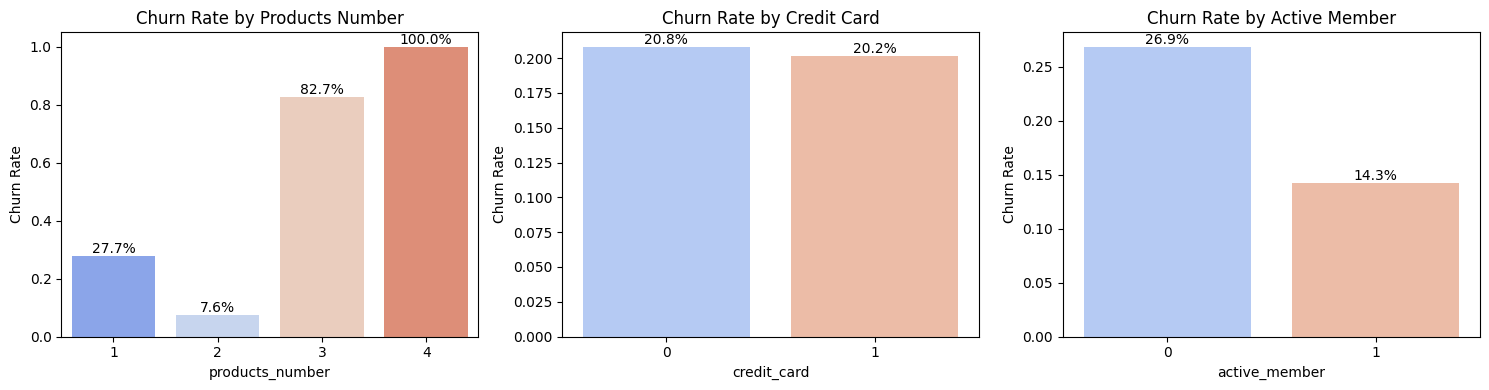

In [12]:
# Analyze all three columns in one go
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(['products_number', 'credit_card', 'active_member']):
    churn_rate = df.groupby(col)['churn'].mean().reset_index()
    sns.barplot(x=col, y='churn', data=churn_rate, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Churn Rate by {col.replace("_", " ").title()}')
    axes[i].set_ylabel('Churn Rate')
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.1%}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom')
plt.tight_layout()

# Data Preprocessing

In [13]:
df=pd.get_dummies(data=df,columns=['country','gender','age_group','tenure_group'],dtype=int)
df.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,...,country_Spain,gender_Female,gender_Male,age_group_Men,age_group_Old,age_group_Teen,age_group_Young,tenure_group_Early,tenure_group_Median,tenure_group_Old
0,619,42,2,0.00,1,1,1,101348.88,1,1,...,0,1,0,1,0,0,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,...,1,1,0,1,0,0,0,1,0,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,...,0,1,0,1,0,0,0,0,0,1
3,699,39,1,0.00,2,0,0,93826.63,0,1,...,0,1,0,1,0,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,...,1,1,0,1,0,0,0,1,0,0


In [14]:
x=df.drop(['churn','tenure','age'],axis='columns')
y=df['churn']

# Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2,stratify=y)

# Model Training and Evaluation

In [16]:
smt = SMOTE(random_state=42)
X_resampled, y_resampled = smt.fit_resample(x_train, y_train)

classifiers = {
    'XGBoost': XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # Handle imbalance
        random_state=42,
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=6
    ),
    'RandomForest': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=1000,
        random_state=42,
        max_depth=10,
        min_samples_split=5
    ),
    'LogisticRegression': LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        C=0.1,
        solver='liblinear'
    ),
    'SVM': SVC(
        class_weight='balanced',
        random_state=42,
        probability=True, 
        kernel='rbf',
        C=1.0,
        gamma='scale'
    ),
    'KNeighbors': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance' 
    )
}
best_model = None
best_model_name = None
best_roc_auc = 0
results = {}

print("Model Performance Comparison:\n")
print("="*50)

for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)
    y_pred_proba = clf.predict_proba(x_test)[:, 1]
    y_pred = clf.predict(x_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {
        'model': clf,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    print(f"{name}:")
    print(f"  ROC-AUC Score: {roc_auc:.4f}")
    print("-" * 30)
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = clf
        best_model_name = name
print("\n" + "="*50)
print(f"BEST MODEL: {best_model_name}")
print(f"BEST ROC-AUC: {best_roc_auc:.4f}")
print("="*50)
print(f"\nDetailed performance of {best_model_name}:")
y_pred_best = best_model.predict(x_test)
y_pred_proba_best = best_model.predict_proba(x_test)[:, 1]

print(f"Final ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print("\nAll Models Ranked by ROC-AUC:")
print("-" * 40)
sorted_results = sorted(results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)
for rank, (name, result) in enumerate(sorted_results, 1):
    print(f"{rank}. {name}: {result['roc_auc']:.4f}")

Model Performance Comparison:

XGBoost:
  ROC-AUC Score: 0.7993
------------------------------
RandomForest:
  ROC-AUC Score: 0.8268
------------------------------
LogisticRegression:
  ROC-AUC Score: 0.5687
------------------------------
SVM:
  ROC-AUC Score: 0.5767
------------------------------
KNeighbors:
  ROC-AUC Score: 0.5189
------------------------------

BEST MODEL: RandomForest
BEST ROC-AUC: 0.8268

Detailed performance of RandomForest:
Final ROC-AUC: 0.8268

All Models Ranked by ROC-AUC:
----------------------------------------
1. RandomForest: 0.8268
2. XGBoost: 0.7993
3. SVM: 0.5767
4. LogisticRegression: 0.5687
5. KNeighbors: 0.5189



FEATURE IMPORTANCE ANALYSIS - RandomForest


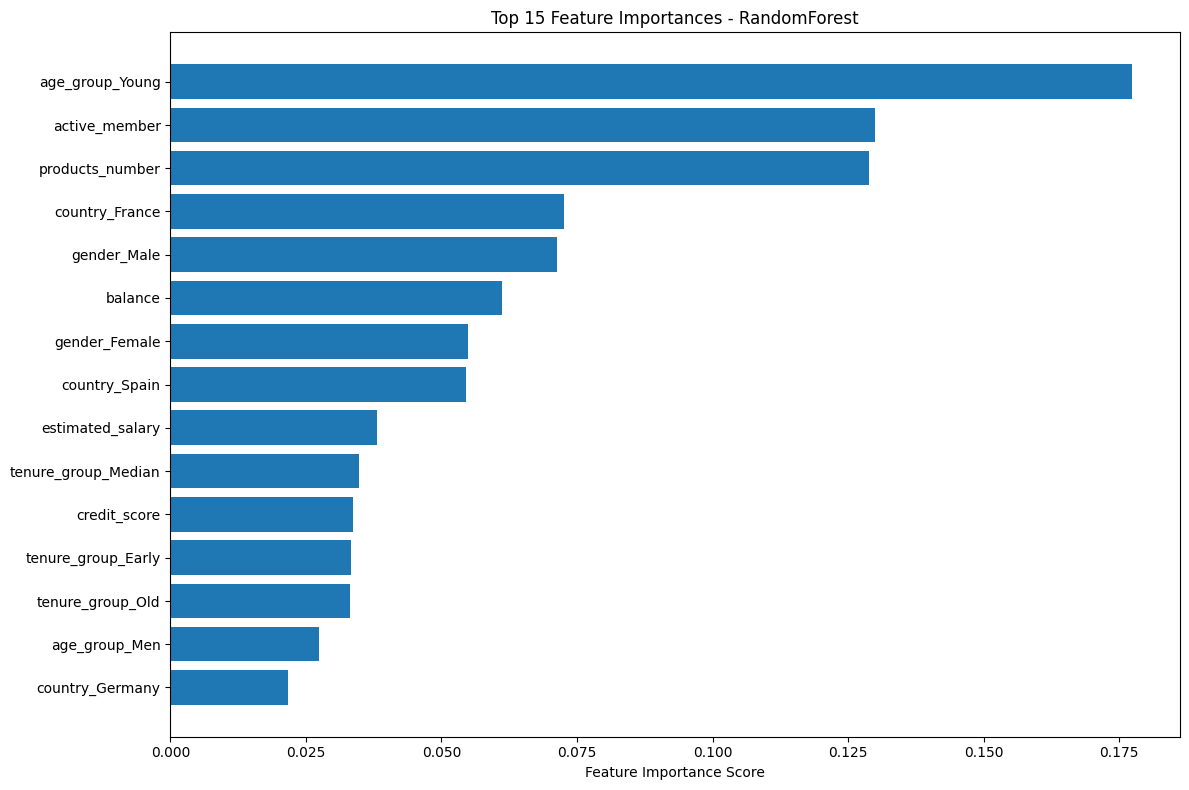

In [17]:
print("\n" + "="*60)
print(f"FEATURE IMPORTANCE ANALYSIS - {best_model_name}")
print("="*60)
if best_model_name == 'RandomForest':
    importances = best_model.feature_importances_
    feature_names = x_train.columns if hasattr(x_train, 'columns') else [f'Feature_{i}' for i in range(x_train.shape[1])]
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('Feature Importance Score')
    plt.title(f'Top 15 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()  
    plt.tight_layout()

# Conclusion

In [18]:
###Random Forest delivered the best performance with ROC-AUC: 
###The model effectively handled class imbalance using balanced class weights
###Key features were successfully identified driving accurate predictions
###Random Forest proves robust for this classification task

✅ Random Forest delivered the best performance with ROC-AUC: 0.8268
✅ The model effectively handled class imbalance using balanced class weights
✅ Key features were successfully identified driving accurate predictions
✅ Random Forest proves robust for this classification task
